In [44]:
import torch
from torch import nn
import torchvision
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import ssl
import seaborn as sns
import time
import torchbearer

sns.set_theme()
ssl._create_default_https_context = ssl._create_unverified_context

In [45]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [46]:
# Hyper-parameters
num_epochs = 150
batch_size = 64
learning_rate = 0.01

Files already downloaded and verified
Files already downloaded and verified


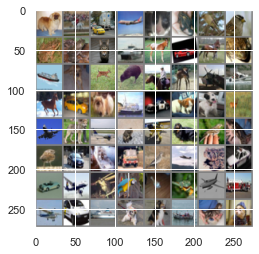

In [47]:
# dataset has PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [48]:

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.covModule = nn.Sequential(
            #input a 3x32x32 image
            nn.Conv2d(3, 64, (5,5)),  #image size will be 64x28x28
            nn.MaxPool2d(2, 2),#image size will be 64x14x14
            nn.Conv2d(64, 64, (5,5)), #image size will be 64x10x10
            nn.MaxPool2d(2, 2), #image size will be 64x5x5
            nn.Conv2d(64, 128, (5,5)) #image size will be 64x1x1
            #nn.MaxPool2d(2, 2), #image size will be 128x1x1
        )
        self.fcModule = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
            #nn.Softmax() #no need for softmax ans CrossEntropy loss already has it
        )
    def forward(self, x):
        x = self.covModule(x)
        x = x.view(-1, 1*1*128)
        output = self.fcModule(x)
        return output

In [49]:
def plotLosses(epochs, Loss, title):
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.plot(epochs, Loss, label = "Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

In [50]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Epoch [1/150], Step [200/782], Loss: 2.2091
Epoch [1/150], Step [400/782], Loss: 1.9977
Epoch [1/150], Step [600/782], Loss: 2.0759
Epoch [2/150], Step [200/782], Loss: 1.9025
Epoch [2/150], Step [400/782], Loss: 1.8206
Epoch [2/150], Step [600/782], Loss: 1.6215
Epoch [3/150], Step [200/782], Loss: 1.7922
Epoch [3/150], Step [400/782], Loss: 1.5917
Epoch [3/150], Step [600/782], Loss: 1.9288
Epoch [4/150], Step [200/782], Loss: 1.4180
Epoch [4/150], Step [400/782], Loss: 1.6137
Epoch [4/150], Step [600/782], Loss: 1.5117
Epoch [5/150], Step [200/782], Loss: 1.5734
Epoch [5/150], Step [400/782], Loss: 1.3108
Epoch [5/150], Step [600/782], Loss: 1.4099
Epoch [6/150], Step [200/782], Loss: 1.2984
Epoch [6/150], Step [400/782], Loss: 1.3545
Epoch [6/150], Step [600/782], Loss: 1.2890
Epoch [7/150], Step [200/782], Loss: 1.3524
Epoch [7/150], Step [400/782], Loss: 1.2194
Epoch [7/150], Step [600/782], Loss: 1.3192
Epoch [8/150], Step [200/782], Loss: 1.1048
Epoch [8/150], Step [400/782], L

KeyboardInterrupt: 

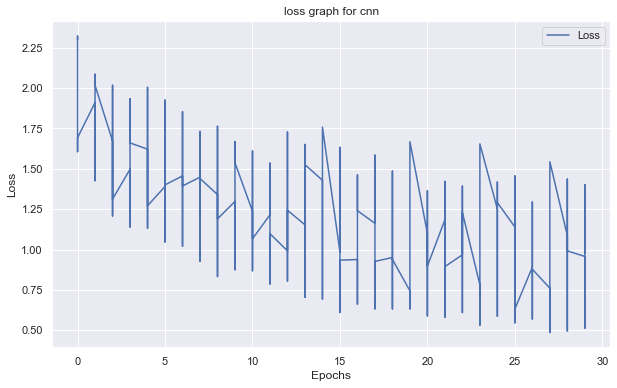

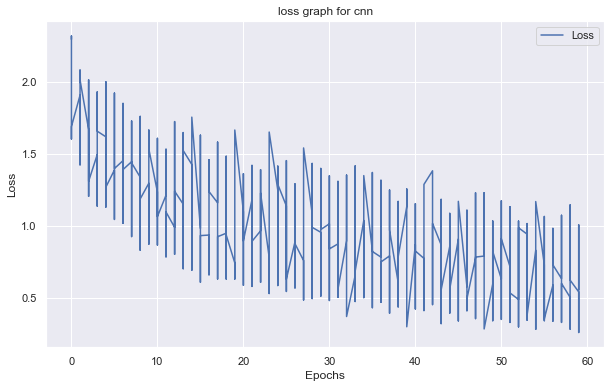

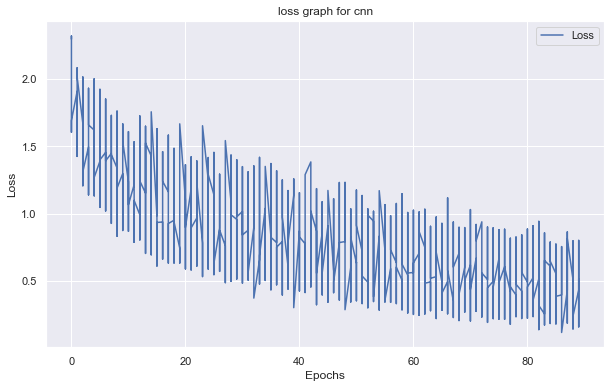

In [51]:
loss_history = []
epochs = []
n_total_steps = len(train_loader)
start_time = time.time()
for epoch in range(num_epochs):
    if epoch == 60:
        learning_rate = learning_rate/10
    if epoch == 120:
        learning_rate = learning_rate/10
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_history.append(loss.item())
        epochs.append(epoch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if (i+1) % 200 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')
    if (epoch+1) % 30 == 0:
        plotLosses(epochs, loss_history, 'loss graph for cnn')

print("--- %s seconds ---" % (time.time() - start_time))

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

In [ ]:

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

In [ ]:
X_train, y_train = next(iter(train_loader))
X_test, y_test = next(iter(test_loader))

In [ ]:
trial = torchbearer.Trial(model, optimizer, criterion, metrics=['loss', 'accuracy', 'top_5_acc'])
trial.with_generators(train_loader, test_generator=test_loader)

trial.run(epochs=10)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(results)

In [ ]:
print(test_loader.items)

In [ ]:
print(len(epochs))
print(len(loss_history))

In [ ]:
plt.plot(epochs,loss_history)
print(len(train_loader))